<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
Prueba Xepelin</p><br>

Se tiene un producto que registra las transacciones de pagos de facturas entre empresas y además, algunos de los montos facturados son financiados por Xepelin. A partir de la información dada se quiere predecir el monto que se pagará a través de este producto en ocutbre del 2021 y cuánto se financiará por Xepelin.

Para este ejercicio se realiza un análisis exploratorio de la información, se crean variables dummies a partir de los  top PayerId y ReceiverId en cuánto a la proporción de monto asociado respecto al total historico y se realizan modelos autoregresivos, una regresión multilineal y modelos de regularización con el fin de obtener un estimado de monto para octubre.

Finalmente, se realiza una regresión lineal para entender la relación entre el monto y el monto financiado por Xepelin y así dar un estimado del monto financiado por Xepelin para octubre usando el monto estimado anteriormente.

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>
Librerías, definición de funciones y lectura de la información
</p>

In [1]:
#import random
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.model_selection import train_test_split
#from math import sqrt

In [67]:
!pip install pmdarima

# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


In [29]:
# Función correlación entre columnas numéricas
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

# Correlación entre columnas numéricas
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)



In [3]:
#lectura de la informacion
data = pd.read_csv('./data_test2.csv')
data.shape

(1200, 7)

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>
Exploración de la información
</p>

In [4]:
data.head(5)

,PayerId,ReceiverId,invoiceId,paidAt,amount,amountfinancedByXepelin,status
0,53,10,18660729,8/23/21 00:00,1490.46,0.00,PAID
1,93,11,18660730,3/22/21 00:00,6418.28,624.48,PAID
2,122,12,18660731,2/18/21 00:00,27979.20,10520.15,PAID
3,85,13,18660732,3/15/21 00:00,183070.77,79421.63,PAID
4,87,14,18660733,7/23/21 00:00,20532.00,20532.00,PAID


In [5]:
data.dtypes

PayerId                      int64
ReceiverId                   int64
invoiceId                    int64
paidAt                      object
amount                     float64
amountfinancedByXepelin    float64
status                      object
dtype: object

In [6]:
#casteo de la fecha
data['Date'] = pd.to_datetime(data['paidAt'])
data = data.sort_values(by='Date', ascending=True)
data.head(5)

,PayerId,ReceiverId,invoiceId,paidAt,amount,amountfinancedByXepelin,status,Date
9,151,19,18660738,2/8/21 00:00,1490.46,0.00,PAID,2021-02-08
8,126,18,18660737,2/8/21 00:00,920.26,0.00,PAID,2021-02-08
15,114,37,18660744,2/15/21 00:00,4035.26,0.00,PAID,2021-02-15
2,122,12,18660731,2/18/21 00:00,27979.20,10520.15,PAID,2021-02-18
12,55,34,18660741,3/2/21 00:00,1477.46,0.00,PAID,2021-03-02


In [7]:
#análisis de valores únicos
print('Número de registros:', data.shape[0])
print('Cantidad de PayerId:',len(data['PayerId'].unique().tolist()))
print('Cantidad de ReceiverId:',len(data['ReceiverId'].unique().tolist()))
print('Cantidad de invoiceId:',len(data['invoiceId'].unique().tolist()))
print('Se tienen los siguientes valores únicos para el campo status:', data['status'].unique().tolist())


Número de registros: 1200
Cantidad de PayerId: 200
Cantidad de ReceiverId: 77
Cantidad de invoiceId: 1200
Se tienen los siguientes valores únicos para el campo status: ['PAID', 'PROCESSING', 'FAILED']


In [8]:
#Campos con entradas en NULL 
data.isnull().any()

PayerId                    False
ReceiverId                 False
invoiceId                  False
paidAt                      True
amount                     False
amountfinancedByXepelin    False
status                     False
Date                        True
dtype: bool

In [9]:
#análisis información en NULL
data_facturas_sin_cerrar = data[data['paidAt'].isnull()]
data_facturas_sin_cerrar.head()

,PayerId,ReceiverId,invoiceId,paidAt,amount,amountfinancedByXepelin,status,Date
721,197,149,18661450,NaN,1490.26,0.00,PROCESSING,NaT
722,153,11,18661451,NaN,1490.26,0.00,PROCESSING,NaT
723,143,14,18661452,NaN,9421.52,2416.86,PROCESSING,NaT
724,195,14,18661453,NaN,4864.20,0.00,PROCESSING,NaT
725,75,14,18661454,NaN,2581.40,0.00,PROCESSING,NaT


In [10]:
#información sin null
facturas_cerradas = data.dropna()

La información que no tiene fecha de pago es aquella que se encuentra en estado PROCESSING o FAILED

In [11]:
print('Estado de la información sin fecha de pago asignada: ', data_facturas_sin_cerrar['status'].unique().tolist())
print('Estado de la información con fecha de pago asignada: ', facturas_cerradas ['status'].unique().tolist())

Estado de la información sin fecha de pago asignada:  ['PROCESSING', 'FAILED']
Estado de la información con fecha de pago asignada:  ['PAID']


<AxesSubplot:>

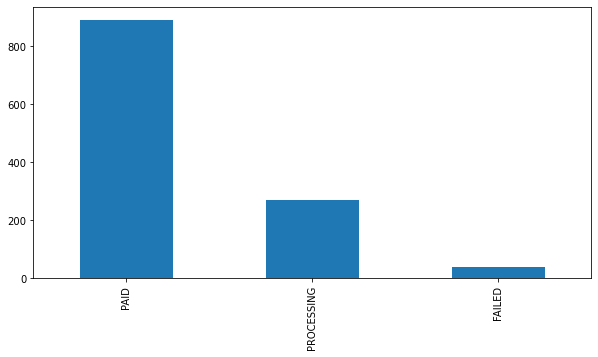

In [12]:
#histograma del estado de las facturas
data['status'].value_counts().plot(kind='bar', figsize=(10,5))

In [13]:
print('Porcentaje de facturas en estado PAID:', data['status'].value_counts()[0]/data.shape[0])
print('Porcentaje de facturas en estado PROCESSING:', data['status'].value_counts()[1]/data.shape[0])
print('Porcentaje de facturas en estado FAILED:', data['status'].value_counts()[2]/data.shape[0])

Porcentaje de facturas en estado PAID: 0.7433333333333333
Porcentaje de facturas en estado PROCESSING: 0.22416666666666665
Porcentaje de facturas en estado FAILED: 0.0325


A partir de lo anterior vemos que se tiene una información considerable en estado PROCESSING y que puede ser valiosa para la estimación del monto que se pagará en octubre a través del producto si logramos estimar la probabilidad de de que una factura en proceso se pague en octubre, sin embargo, para esto necesitaríamos por lo menos las fechas en las que se generaron las facturas y no tenemos esta información. 

Realizaremos los modelos de predicción sobre las facturas cerradas. 

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>
Generacion variables dummies
</p>

In [14]:
facturas_cerradas.head(5)

,PayerId,ReceiverId,invoiceId,paidAt,amount,amountfinancedByXepelin,status,Date
9,151,19,18660738,2/8/21 00:00,1490.46,0.00,PAID,2021-02-08
8,126,18,18660737,2/8/21 00:00,920.26,0.00,PAID,2021-02-08
15,114,37,18660744,2/15/21 00:00,4035.26,0.00,PAID,2021-02-15
2,122,12,18660731,2/18/21 00:00,27979.20,10520.15,PAID,2021-02-18
12,55,34,18660741,3/2/21 00:00,1477.46,0.00,PAID,2021-03-02


Por el momento la única información que tenemos para realizar una estimación del monto son PayerId y ReceiverId. Estas son variables categóricas que necesitamos transformar en variables dummies para poder ser implementadas en los modelos. 

En el análisis de la información encontramos que se tienen 200 valores únicos para PayerId y 77 para ReceiverId. Para no obtener un agran cantidad de variables dummies y evitar colinealidad entre ellas tomaremos el top 10 de ellos con mayor porcentaje de monto respecto al monto total histórico.

In [15]:
#Análisis PayerId con mayor porcentaje de monto
n = 10
monto_por_PayerId = facturas_cerradas[['amount','PayerId']].groupby('PayerId').sum()
monto_por_PayerId = monto_por_PayerId.sort_values(by='amount', ascending=False)
monto_por_PayerId['cum_percent'] = 100*(monto_por_PayerId['amount'].cumsum() / monto_por_PayerId['amount'].sum())
monto_por_PayerId = monto_por_PayerId.reset_index(level=0)
top_PayerId = monto_por_PayerId['PayerId'][0:n]

print('Los' , n, 'top PayerId representan el',monto_por_PayerId['cum_percent'][n-1],'por ciento del monto total')

Los 10 top PayerId representan el 42.26656091060109 por ciento del monto total


In [16]:
#Análisis ReceiverId con mayor porcentaje de monto
monto_por_ReceiverId = facturas_cerradas[['amount','ReceiverId']].groupby('ReceiverId').sum()
monto_por_ReceiverId = monto_por_ReceiverId.sort_values(by='amount', ascending=False)
monto_por_ReceiverId['cum_percent']=100*(monto_por_ReceiverId['amount'].cumsum()/monto_por_ReceiverId['amount'].sum())
monto_por_ReceiverId = monto_por_ReceiverId.reset_index(level=0)
top_ReceiverId = monto_por_ReceiverId['ReceiverId'][0:n]

print('Los' , n,'top ReceiverId representan el',monto_por_ReceiverId['cum_percent'][n-1],'por ciento del monto total')

Los 10 top ReceiverId representan el 57.80019666798369 por ciento del monto total


Los PayerId y ReceiverId elegidos representan un porcentaje considerable del monto y pueden ser bastante útiles a la hora de realizar los modelos.

In [17]:
#Creación de variables top_PayerId y op_ReceiverId
# estas variables tienen entrada el ID correspondiente si pertenece a la lista top y 0 en caso contrario
column_PayerId = np.where(facturas_cerradas['PayerId'].isin(top_PayerId), facturas_cerradas['PayerId'], 0)
column_ReceiverId  = np.where(facturas_cerradas['ReceiverId'].isin(top_ReceiverId), facturas_cerradas['ReceiverId'],0)
facturas_cerradas['top_PayerId'] = column_PayerId
facturas_cerradas['top_ReceiverId'] = column_ReceiverId
facturas_cerradas.head(10)

,PayerId,ReceiverId,invoiceId,paidAt,amount,amountfinancedByXepelin,status,Date,top_PayerId,top_ReceiverId
9,151,19,18660738,2/8/21 00:00,1490.46,0.00,PAID,2021-02-08,0,0
8,126,18,18660737,2/8/21 00:00,920.26,0.00,PAID,2021-02-08,0,0
15,114,37,18660744,2/15/21 00:00,4035.26,0.00,PAID,2021-02-15,0,0
2,122,12,18660731,2/18/21 00:00,27979.20,10520.15,PAID,2021-02-18,0,0
12,55,34,18660741,3/2/21 00:00,1477.46,0.00,PAID,2021-03-02,0,0
51,159,16,18660780,3/4/21 00:00,8688.40,737.99,PAID,2021-03-04,0,16
3,85,13,18660732,3/15/21 00:00,183070.77,79421.63,PAID,2021-03-15,0,0
54,47,79,18660783,3/16/21 00:00,7267.40,988.02,PAID,2021-03-16,0,0
49,145,89,18660778,3/16/21 00:00,6380.00,6380.00,PAID,2021-03-16,0,0
18,125,44,18660747,3/16/21 00:00,6635.20,516.70,PAID,2021-03-16,0,0


In [18]:
#Creación de variables dummies 
data_model = facturas_cerradas[['Date', 'top_PayerId', 'top_ReceiverId', 'amount', 'amountfinancedByXepelin']]
data_model= pd.get_dummies(data=data_model, columns=['top_PayerId', 'top_ReceiverId'])
data_model = data_model.drop(columns=['top_PayerId_0', 'top_ReceiverId_0'])
data_model.head(5)

,Date,amount,amountfinancedByXepelin,top_PayerId_7,top_PayerId_8,top_PayerId_66,top_PayerId_67,top_PayerId_106,top_PayerId_109,top_PayerId_157,...,top_ReceiverId_14,top_ReceiverId_16,top_ReceiverId_21,top_ReceiverId_35,top_ReceiverId_46,top_ReceiverId_58,top_ReceiverId_85,top_ReceiverId_87,top_ReceiverId_126,top_ReceiverId_135
9,2021-02-08,1490.46,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2021-02-08,920.26,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,2021-02-15,4035.26,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-02-18,27979.20,10520.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,2021-03-02,1477.46,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>
Preparación data
</p>

Con el fin de tener un histórico continuo se realiza una agrupación de las variables por día y se completan con 0 los días en que no hubo pago de facturas.

In [19]:
data_model = data_model.groupby('Date', as_index=False).sum()
data_model  = (data_model .set_index('Date')
      .reindex(pd.date_range(min(data_model ['Date']), max(data_model ['Date']), freq='D'))
      .rename_axis(['Date'])
      .fillna(0)
      .reset_index())
data_model.head(5)

,Date,amount,amountfinancedByXepelin,top_PayerId_7,top_PayerId_8,top_PayerId_66,top_PayerId_67,top_PayerId_106,top_PayerId_109,top_PayerId_157,...,top_ReceiverId_14,top_ReceiverId_16,top_ReceiverId_21,top_ReceiverId_35,top_ReceiverId_46,top_ReceiverId_58,top_ReceiverId_85,top_ReceiverId_87,top_ReceiverId_126,top_ReceiverId_135
0,2021-02-08,2410.72,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-02-09,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-02-10,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-02-11,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-02-12,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='Date'>

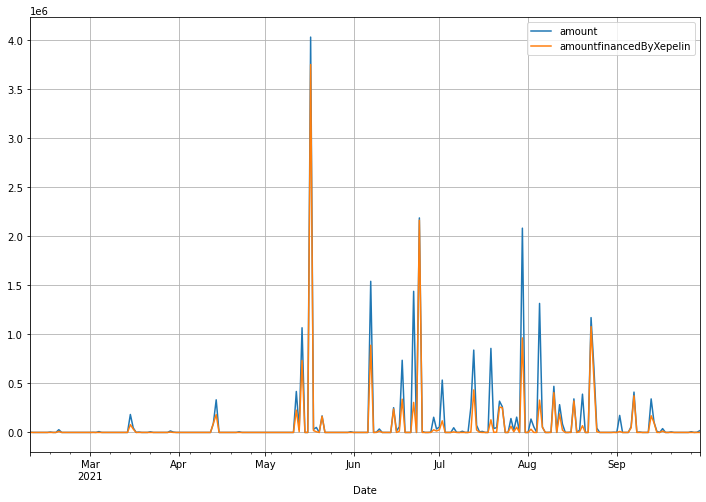

In [20]:
# Gráfico de monto pagado por día
data_model.plot(x='Date', y=['amount', 'amountfinancedByXepelin'], figsize=(12,8), grid=True)

Una manera de suavizar la variable a predecir es agrupar los montos semanalmente, de este modo podría verse una tendencia o estacionalidad más clara de la variable y también se evitarían los ceros presentes en el histórico diario. La desventaja en este caso es que tendríamos menos registros, pero es una buena opción para intentar realizar los modelos.

<AxesSubplot:xlabel='Date'>

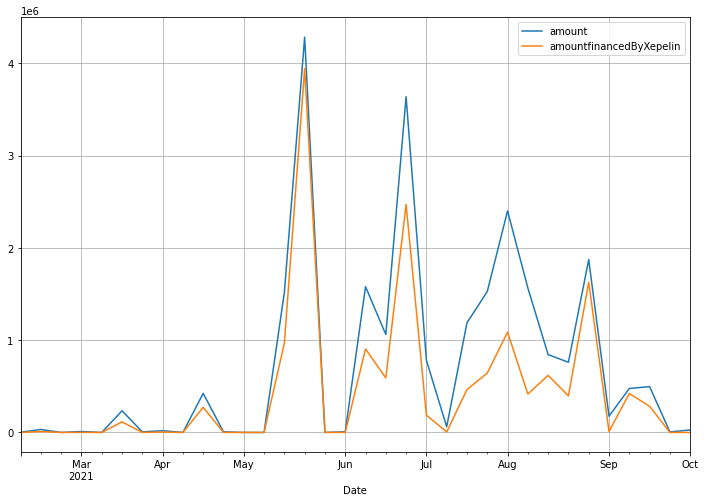

In [21]:
#data semanal
data_model_week = data_model.resample('W', on='Date')['amount','amountfinancedByXepelin'].sum()
data_model_week = data_model_week.reset_index(level=0)
data_model_week.plot(x='Date', y=['amount', 'amountfinancedByXepelin'], figsize=(12,8), grid=True)

En la gráfica de los montos diarios se ve la presencia de outliers pero no serán removidos o sustituidos ya que marcan la tendencia decreciente del monto y podrían ser explicados por las variables dummies construidas. 

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>
Modelos usando data diaria
</p>

A continuación se construyen diferentes modelos autoregresivos y de regularización. Para hacerlos comparables y elegir el "mejor modelo" se toman los mismos intervalos de entrenamiento y test y se comparan a partir de los MAPE obtenidos. Como nos interesa hacer la predicción de los montos para octubre los MAPE serán calculados mensualmente.

El entrenamiento se hará de febrero a julio y el test en agosto y septiembre.

## ARIMAS

Se realizan modelos arima con la información diaria usando valores del 0 al 9 para el parametro lag y se comparan los errores de ajuste de entrenamiento y test entre ellos a partir de los valores agregados mensualmente.

In [676]:
#from pandas.plotting import lag_plot
#series = data_model['amount']
#lag_plot(series)
#plt.show()

In [22]:
df_stationarityTest = adfuller(data_model['amount'], autolag='AIC')
print("P-value: ", df_stationarityTest[1])

P-value:  1.6386333822058034e-28


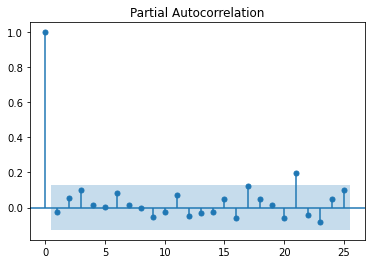

In [23]:
pacf = plot_pacf(data_model['amount'], lags=25)

In [24]:
#Cálculo de data mensual real
data_model['Mes'] = data_model['Date'].dt.month 
monto_mensual = data_model[['Mes', 'amount']].groupby('Mes').sum()
monto_mensual

,amount
Mes,
2,34425.18
3,269826.65
4,429642.39
5,5806452.68
6,6469632.61
7,5765920.25
8,5044795.41
9,1178392.90


In [25]:
#partición de información en entrenamiento y test
date_test = '2021-08-01'
date_test_index = data_model[data_model['Date'] == date_test].index.astype(int)[0]
train_data = data_model['amount'][:date_test_index]
test_data = data_model['amount'][date_test_index:]

In [26]:
#Ejecución de modelos arima usando diferentes valores para el parametro lag y cálculo de MAPES por mes
df_predict = pd.DataFrame(columns = ['Fit_febrero','Fit_marzo', 'Fit_abril','Fit_mayo',
                                     'Fit_junio', 'Fit_julio', 'Pred_agosto','Pred_septiembre'])

for i in range(10):
    ar_model = AutoReg(train_data, lags=i).fit()
    pred = ar_model.predict(start=len(train_data), end=(len(data_model)-1), dynamic=False)
    
    fit_febrero = sum(ar_model.fittedvalues[:data_model[data_model['Date'] == '2021-03-01'].index.astype(int)[0]])
    fit_marzo = sum(ar_model.fittedvalues[data_model[data_model['Date'] == '2021-03-01'].index.astype(int)[0] : data_model[data_model['Date'] == '2021-04-01'].index.astype(int)[0]])
    fit_abril = sum(ar_model.fittedvalues[data_model[data_model['Date'] == '2021-04-01'].index.astype(int)[0] : data_model[data_model['Date'] == '2021-05-01'].index.astype(int)[0]])
    fit_mayo = sum(ar_model.fittedvalues[data_model[data_model['Date'] == '2021-05-01'].index.astype(int)[0] : data_model[data_model['Date'] == '2021-06-01'].index.astype(int)[0]])
    fit_junio = sum(ar_model.fittedvalues[data_model[data_model['Date'] == '2021-06-01'].index.astype(int)[0] : data_model[data_model['Date'] == '2021-07-01'].index.astype(int)[0]])
    fit_julio = sum(ar_model.fittedvalues[data_model[data_model['Date'] == '2021-07-01'].index.astype(int)[0] : data_model[data_model['Date'] == '2021-08-01'].index.astype(int)[0]])
    
    pred_agosto = sum(pred[:31])
    pred_septiembre = sum(pred[32:])
    df_predict.loc[i] = [fit_febrero, fit_marzo, fit_abril, fit_mayo, fit_junio, fit_julio, pred_agosto,pred_septiembre] 
    

df_mapes = pd.DataFrame(columns = ['MAPE_train','MAPE_test'])

for i in range(10):
    mape_train = mean_absolute_percentage_error(monto_mensual['amount'][:6], df_predict.iloc[i][:6])
    mape_test = mean_absolute_percentage_error(monto_mensual['amount'][6:], df_predict.iloc[i][6:])
    df_mapes.loc[i] = [mape_train, mape_test]
    
    
df_mapes

,MAPE_train,MAPE_test
0,14.016827,0.996247
1,14.672134,1.001462
2,13.630934,1.000582
3,12.279357,0.996439
4,12.085261,1.000509
5,12.196880,1.007012
6,12.222035,1.013119
7,12.306568,1.019612
8,12.247779,1.025662
9,12.590502,1.032876


El mejor modelo ARIMA de los construídos lo podemos obtener con el parametro lag igual a 4, sin embargo los errores de entrenamiento y test son similares para todos los modelos. Aunque son buenos errores mensuales sería ideal que el error de entrenamiento fuera más cercano al error de test y de este modo representaría mejor la información.

## Análisis de correlación entre variables para modelos de regresión multilineal

Antes de realizar modelos de regresión multilineal es importante realizar una análisis de correlacion entre las variables. En este caso la presencia de variables dummies podría mostrar altas correlaciones.

In [27]:
data_model_elastic = data_model.copy()
data_model_elastic.head(5)

,Date,amount,amountfinancedByXepelin,top_PayerId_7,top_PayerId_8,top_PayerId_66,top_PayerId_67,top_PayerId_106,top_PayerId_109,top_PayerId_157,...,top_ReceiverId_16,top_ReceiverId_21,top_ReceiverId_35,top_ReceiverId_46,top_ReceiverId_58,top_ReceiverId_85,top_ReceiverId_87,top_ReceiverId_126,top_ReceiverId_135,Mes
0,2021-02-08,2410.72,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,2021-02-09,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,2021-02-10,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2021-02-11,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2021-02-12,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [28]:
del data_model_elastic['amountfinancedByXepelin']
del data_model_elastic['Mes']
del data_model_elastic['Date']

In [30]:
corr_matrix = data_model_elastic.select_dtypes(include=['float64', 'int']) \
              .corr(method='pearson')
display(tidy_corr_matrix(corr_matrix).head(5))

,variable_1,variable_2,r,abs_r
395,top_ReceiverId_87,top_ReceiverId_85,0.736917,0.736917
375,top_ReceiverId_85,top_ReceiverId_87,0.736917,0.736917
345,top_ReceiverId_58,top_PayerId_175,0.725495,0.725495
205,top_PayerId_175,top_ReceiverId_58,0.725495,0.725495
373,top_ReceiverId_85,top_ReceiverId_58,0.710252,0.710252


En la siguiente tabla vemos que ninguna de las variables tiene correlación alta con la variable dependiente.

In [31]:
tidy_corr_matrix(corr_matrix)[tidy_corr_matrix(corr_matrix)['variable_1'] == 'amount']

,variable_1,variable_2,r,abs_r
12,amount,top_ReceiverId_16,0.498371,0.498371
9,amount,top_PayerId_175,0.483043,0.483043
5,amount,top_PayerId_106,0.480294,0.480294
18,amount,top_ReceiverId_87,0.442293,0.442293
16,amount,top_ReceiverId_58,0.435353,0.435353
11,amount,top_ReceiverId_14,0.396968,0.396968
15,amount,top_ReceiverId_46,0.395737,0.395737
8,amount,top_PayerId_173,0.393709,0.393709
10,amount,top_PayerId_184,0.363716,0.363716
17,amount,top_ReceiverId_85,0.356730,0.356730


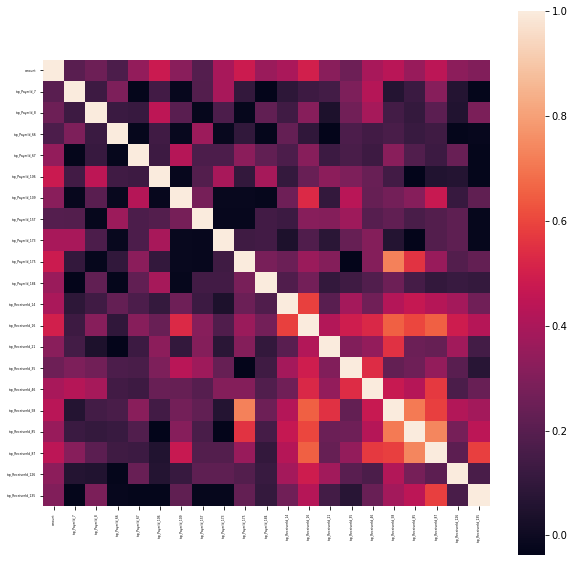

In [32]:
# Heatmap matriz de correlaciones
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

sns.heatmap(
    corr_matrix,
    square    = True,
    ax        = ax
)

ax.tick_params(labelsize = 3)

En el anterior gráfico vemos las correlaciones entre todas las variables. En general las correlaciones son bajas y por esto no eliminaremos variables para la construcción de los siguientes modelos.

In [33]:
#Partición de información en entrenamiento y test
#date_test_index = data_model[data_model['Date'] == date_test].index.astype(int)[0]
x = data_model_elastic.loc[:, data_model_elastic.columns != 'amount']
y = pd.DataFrame(data_model_elastic['amount'])
x_train = x[:date_test_index]
x_test = x[date_test_index:]
y_train = y[:date_test_index]
y_test = y[date_test_index:]

## Regresión Lineal

In [34]:
# Creación y entrenamiento del modelo
# ==============================================================================
modelo = LinearRegression(normalize=True)
modelo.fit(X = x_train, y = y_train)

LinearRegression(normalize=True)

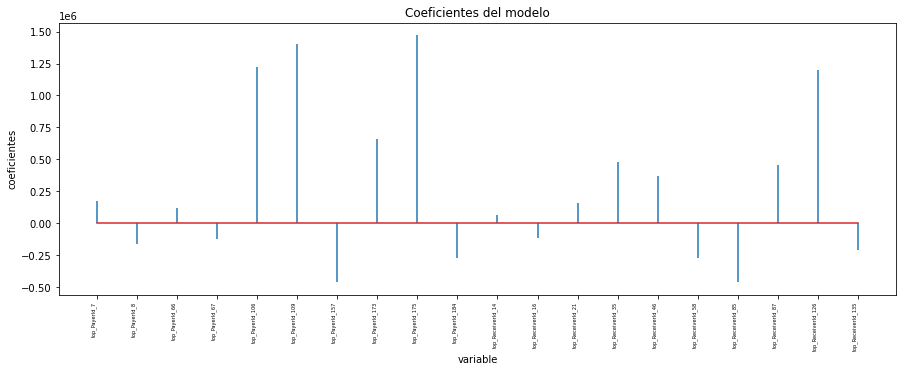

In [35]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': x_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(15, 5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [37]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=x_test)
predicciones = predicciones.flatten()
predicciones

array([ 2.12344864e+03,  2.44860537e+06,  3.01108667e+05,  2.12344864e+03,
       -1.14586781e+06,  1.20298688e+06,  2.12344864e+03,  2.12344864e+03,
        2.12344864e+03,  4.02340459e+06,  2.12344864e+03,  1.12272801e+06,
       -5.69591735e+05,  2.12344864e+03,  2.12344864e+03, -4.54910984e+05,
        2.43607900e+06,  2.12344864e+03, -1.05405632e+06,  8.89426775e+05,
        2.12344864e+03,  2.12344864e+03,  1.48450696e+06, -9.35967837e+04,
        5.01599512e+05,  2.12344864e+03,  2.12344864e+03,  2.12344864e+03,
        2.12344864e+03,  2.12344864e+03,  2.12344864e+03,  2.12344864e+03,
        2.12344864e+03,  2.12344864e+03,  2.12344864e+03,  2.12344864e+03,
        7.49921534e+05,  1.47630184e+06, -2.68456395e+05, -5.69591735e+05,
        2.12344864e+03,  2.12344864e+03,  2.12344864e+03,  1.84867547e+06,
       -1.52335671e+05, -1.79313072e+04,  2.12344864e+03,  2.12344864e+03,
        2.12344864e+03,  2.12344864e+03, -3.90510527e+05,  2.12344864e+03,
        2.12344864e+03,  

Para la regresión multilineal usando todas las variables obtenemos coeficientes negativos, lo cual no tiene sentido porque significaría que el hecho de que alguna empresa pague o reciba el pago de una factura afecta negativamente al monto y representaría un mono negativo dentro del monto total. Esto podría explicarse por causalidad de correlaciones con otras variables pero no tenemos la información en este momento para saberlo.

Además, se obtienen predicciones negativas, lo que tampoco tiene sentido y por tanto este modelo queda descartado.

## Ridge

Se realiza un modelo Ridge haciendo validación cruzada para obtener el mejor alpha y se realiza un análisis de la variación de los coeficientes y del RMSE respecto a la variación del alpha.

In [38]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto RidgeCV utiliza el mean squared error
modelo = RidgeCV(
            alphas          = np.logspace(-10, 2, 200),
            fit_intercept   = True,
            normalize       = True,
            store_cv_values = True
         )

_ = modelo.fit(X = x_train, y = y_train)

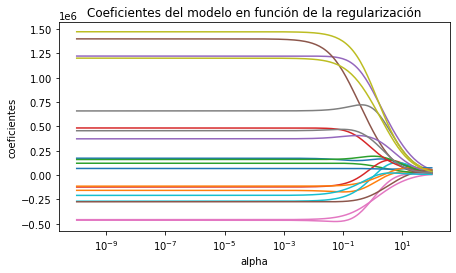

In [39]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = modelo.alphas
coefs = []

for alpha in alphas:
    modelo_temp = Ridge(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(x_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');
plt.axis('tight')
plt.show()

Podemos ver que a medida que aumenta el alpha los coeficientes tienden a cero

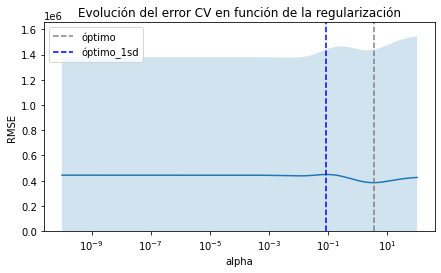

In [40]:
# Evolución del error en función de alpha
# ==============================================================================
# modelo.cv_values almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_samples, n_targets, n_alphas)
mse_cv = modelo.cv_values_.reshape((-1, 200)).mean(axis=0)
mse_sd = modelo.cv_values_.reshape((-1, 200)).std(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas[rmse_cv == min_rsme_1sd]


# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo.alphas, rmse_cv)
ax.fill_between(
    modelo.alphas,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)
ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();


No hay una variación significativa en el RMSE conforme el alpha varia. Hay un punto de inflexión que define el mejor alpha.

In [41]:
# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 3.5707859649004554


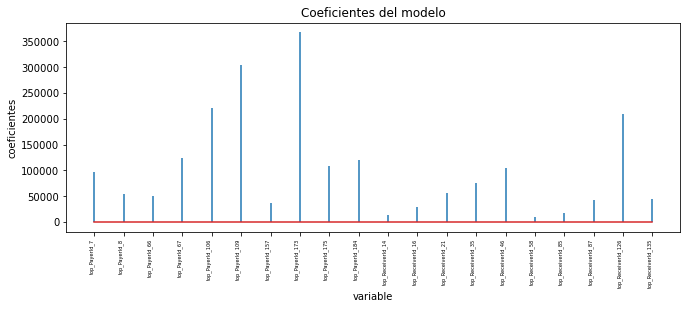

In [42]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': x_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

Podemos ver que en este caso los coeficientes de todas las variables son positivos, algunos con un peso mayor a otros. Hasta este momento los resultados del modelo tienen sentido.

In [43]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=x_test)
predicciones = predicciones.flatten()

In [44]:
# Error de test del modelo 
# ==============================================================================
rmse_ridge = mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones,
                squared = False
             )
print("")
print(f"El error (rmse) de test es: {rmse_ridge}")


El error (rmse) de test es: 233048.13904054425


## Lasso

Mediante lasso se busca excluir variables que no sean relevantes para el modelo. 
Se realiza al igual que en el modelo anterior una validación cruzada y análisis de los coeficientes y el RMSE.

In [45]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto LassoCV utiliza el mean squared error
modelo = LassoCV(
            alphas          = np.logspace(-10, 3, 200),
            normalize       = True,
            cv              = 10
         )
_ = modelo.fit(X = x_train, y = y_train)

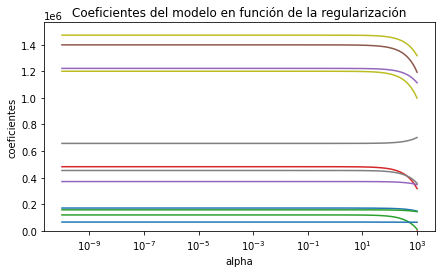

In [46]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = modelo.alphas_
coefs = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(x_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_ylim([-15,None])
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');

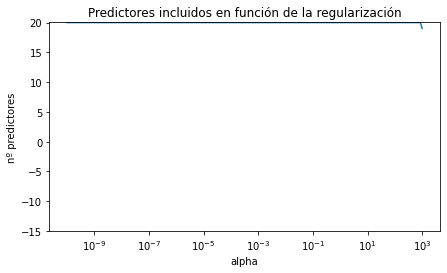

In [47]:
# Número de predictores incluidos (coeficiente !=0) en función de alpha
# ==============================================================================
alphas = modelo.alphas_
n_predictores = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(x_train, y_train)
    coef_no_cero = np.sum(modelo_temp.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-15,None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº predictores')
ax.set_title('Predictores incluidos en función de la regularización');

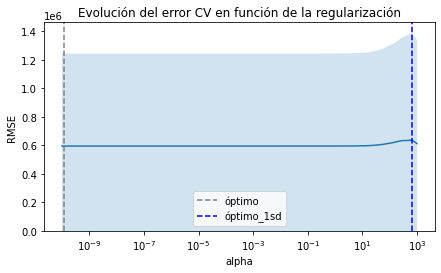

In [48]:
# Evolución del error en función de alpha
# ==============================================================================
# modelo.mse_path_ almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_alphas, n_folds)
mse_cv = modelo.mse_path_.mean(axis=1)
mse_sd = modelo.mse_path_.std(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas_[rmse_cv == min_rsme_1sd]

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo.alphas_, rmse_cv)
ax.fill_between(
    modelo.alphas_,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)

ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();

In [49]:
# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 1.1623224686798542e-10


En los gráficos obtenidos se puede ver que no hay una variación ni en los coeficientes ni en el RMSE conforme el aplha varía. El número de predictores para los diferentes modelos siempre es igual al número total de predictores y el alpha es nulo, entonces este modelo es equivalente al modelo anterior.

## Elastic net

Elastic net busca encontrarun punto medio entre Ridge y Lasso. 
Se realiza el mismo proceso que con los métodos anteriores.

In [50]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto ElasticNetCV utiliza el mean squared error
modelo = ElasticNetCV(
            l1_ratio        = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
            alphas          = np.logspace(-10, 3, 200),
            normalize       = True,
            cv              = 10
         )
_ = modelo.fit(X = x_train, y = y_train)

In [51]:
# Evolución del error en función de alpha y l1_ratio
# ==============================================================================
# modelo.mse_path_ almacena el mse de cv para cada valor de alpha y l1_ratio.
# Tiene dimensiones (n_l1_ratio, n_alpha, n_folds)

# Error medio de las 10 particiones por cada valor de alpha y l1_ratio 
mean_error_cv = modelo.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha)
# Se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [modelo.l1_ratio, modelo.alphas_],
                                    names     = ['l1_ratio', 'modelo.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv

,l1_ratio,modelo.alphas_,mse_cv,rmse_cv
267,0.10,4.198707e-02,1.552114e+11,393968.766618
463,0.50,7.663411e-02,1.552153e+11,393973.700494
1237,0.99,3.827494e+00,1.552206e+11,393980.409559
1048,0.95,7.316807e-01,1.552221e+11,393982.367876
68,0.00,3.612343e-02,1.552321e+11,393994.988972
...,...,...,...,...
1395,0.99,1.825183e-10,3.552233e+11,596006.124482
1396,0.99,1.570290e-10,3.552233e+11,596006.124493
1397,0.99,1.350994e-10,3.552233e+11,596006.124503
1398,0.99,1.162322e-10,3.552233e+11,596006.124512


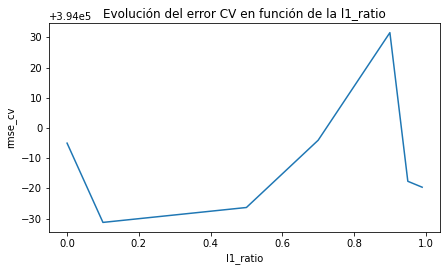

In [52]:
# Mejor valor encontrado para cada l1_ratio
fig, ax = plt.subplots(figsize=(7, 3.84))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');

In [53]:
# Mejor valor alpha y l1_ratio_ encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {modelo.l1_ratio_}")

Mejor valor de alpha encontrado: 0.04198707084443923
Mejor valor de l1_ratio encontrado: 0.1


In [55]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': x_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

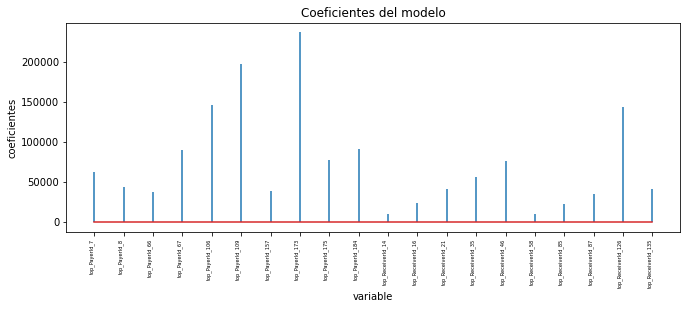

In [56]:
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [59]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=x_test)
predicciones = predicciones.flatten()

In [60]:
# Error de test del modelo 
# ==============================================================================
rmse_elastic = mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones,
                squared = False
               )
print("")
print(f"El error (rmse) de test es: {rmse_elastic}")


El error (rmse) de test es: 190235.10722916367


El modelo elastic net obtenido tiene los mismos coeficientes que el modelo ridge. 


Resumiendo, los métodos de regularización dan como resultado el mismo modelo.
Calcularemos el MAPE de entrenamiento y el MAPE de test para comparar el ajuse de este modelo con el ARIMA seleccionado.

In [61]:
#cálculo de MAPE de entrenamiento y test usando el modelo de regularización 
modelo = RidgeCV(
            alphas          = np.logspace(-10, 2, 200),
            fit_intercept   = True,
            normalize       = True,
            store_cv_values = True
         )

_ = modelo.fit(X = x_train, y = y_train)

In [63]:
ridge_fitted = modelo.predict(X=x_train)
predicciones = modelo.predict(X=x_test)

In [64]:
fit_ridge_febrero = sum(ridge_fitted[:data_model[data_model['Date'] == '2021-03-01'].index.astype(int)[0]])
fit_ridge_marzo = sum(ridge_fitted[data_model[data_model['Date'] == '2021-03-01'].index.astype(int)[0] : data_model[data_model['Date'] == '2021-04-01'].index.astype(int)[0]])
fit_ridge_abril = sum(ridge_fitted[data_model[data_model['Date'] == '2021-04-01'].index.astype(int)[0] : data_model[data_model['Date'] == '2021-05-01'].index.astype(int)[0]])
fit_ridge_mayo = sum(ridge_fitted[data_model[data_model['Date'] == '2021-05-01'].index.astype(int)[0] : data_model[data_model['Date'] == '2021-06-01'].index.astype(int)[0]])
fit_ridge_junio = sum(ridge_fitted[data_model[data_model['Date'] == '2021-06-01'].index.astype(int)[0] : data_model[data_model['Date'] == '2021-07-01'].index.astype(int)[0]])
fit_ridge_julio = sum(ridge_fitted[data_model[data_model['Date'] == '2021-07-01'].index.astype(int)[0] : data_model[data_model['Date'] == '2021-08-01'].index.astype(int)[0]])
pred_ridge_agosto = sum(predicciones[:31])
pred_ridge_septiembre = sum(predicciones[32:])

df_ridge_predict = [fit_ridge_febrero, fit_ridge_marzo, fit_ridge_abril, fit_ridge_mayo,
                               fit_ridge_junio, fit_ridge_julio, pred_ridge_agosto, pred_ridge_septiembre]

mape_train = mean_absolute_percentage_error(monto_mensual['amount'][:6], df_ridge_predict[:6])
mape_test = mean_absolute_percentage_error(monto_mensual['amount'][6:], df_ridge_predict[6:])
    

In [65]:
print('El MAPE calculado sobre la data de entrenamiento es', mape_train,'por ciento')
print('El MAPE calculado sobre la data de testeo', mape_test,'por ciento')

El MAPE calculado sobre la data de entrenamiento es 5.7696935665338955 por ciento
El MAPE calculado sobre la data de testeo 1.2148546358873138 por ciento


<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>
Selección del modelo
</p>

Entre el modelo ARIMA y el ridge el que mejor se ajusta tanto a la data de entrenamiento como test es el segundo, además de tener información de otras variables. Usaremos este modelo para realizar la estimación del monto de octubre y en base calculamos el monto financiado por Xepelin.

El problema con este modelo es que debemos conocer los valores futuros de las variables dummies y es complicado hacer esta estimación con la información que tenemos. Se intenta hacer esto por medio de autoarimas.

In [68]:
modelo_final = RidgeCV(
            alphas          = np.logspace(-10, 2, 200),
            fit_intercept   = True,
            normalize       = True,
            store_cv_values = True
         )

_ = modelo_final.fit(X = x, y = y)

In [69]:
x.columns

Index(['top_PayerId_7', 'top_PayerId_8', 'top_PayerId_66', 'top_PayerId_67',
       'top_PayerId_106', 'top_PayerId_109', 'top_PayerId_157',
       'top_PayerId_173', 'top_PayerId_175', 'top_PayerId_184',
       'top_ReceiverId_14', 'top_ReceiverId_16', 'top_ReceiverId_21',
       'top_ReceiverId_35', 'top_ReceiverId_46', 'top_ReceiverId_58',
       'top_ReceiverId_85', 'top_ReceiverId_87', 'top_ReceiverId_126',
       'top_ReceiverId_135'],
      dtype='object')

In [70]:
#autoarima para cada una de las variables dummy
modelo_prueba = pm.auto_arima(x['top_ReceiverId_135'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-189.038, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-193.038, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-191.038, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-191.038, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-197.116, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-195.278, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-195.286, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-193.293, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.305 seconds


In [71]:
#predicciones diarias para octubre
n_periods = 31
fc, confint = modelo_prueba.predict(n_periods=n_periods, return_conf_int=True)

In [72]:
fc

array([0.02553191, 0.02553191, 0.02553191, 0.02553191, 0.02553191,
       0.02553191, 0.02553191, 0.02553191, 0.02553191, 0.02553191,
       0.02553191, 0.02553191, 0.02553191, 0.02553191, 0.02553191,
       0.02553191, 0.02553191, 0.02553191, 0.02553191, 0.02553191,
       0.02553191, 0.02553191, 0.02553191, 0.02553191, 0.02553191,
       0.02553191, 0.02553191, 0.02553191, 0.02553191, 0.02553191,
       0.02553191])

Como las predicciones de estas variables dummies deben ser 0 o 1 podríamos inferir que para el top_ReceiverId_135 todos sus valores en octubre son 0.

Se realizó el mismo ejercicio para todas las variables y se obtiene el mismo resultado. En este caso la predicción del monto para octubre estaría definida por el intercepto del modelo ridge.

In [73]:
Prediccion_octubre = modelo_final.intercept_*31
Prediccion_octubre[0]

1442740.503450823

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>
Estimación monto financiado por Xepelin
</p>

Para estimar el monto financiado por Xepelin realizamos una regresión lineal que relacione el monto y el monto financiado por Xepelin.

In [75]:
#modelo monto financiado por Xepelin
x_reg = data_model['amount']
y_reg = data_model['amountfinancedByXepelin']

En el siguiente gráfico vemos la relación entre ambas variables. Se puede ver la correlación positiva entre ellas y la presencia de outliers que pueden causar problema en el momento de hacer la regresión, por esto los eliminamos.

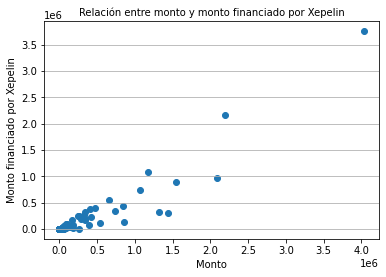

In [76]:
%matplotlib inline

fig, axis = plt.subplots()
# Grid lines, Xticks, Xlabel, Ylabel

axis.yaxis.grid(True)
axis.set_title('Relación entre monto y monto financiado por Xepelin',fontsize=10)
axis.set_xlabel('Monto',fontsize=10)
axis.set_ylabel('Monto financiado por Xepelin',fontsize=10)

X = x_reg
Y = y_reg

axis.scatter(X, Y)
plt.show()

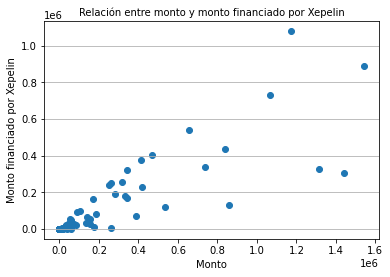

In [77]:
#data sin outliers
data_reg = data_model[data_model['amount'] < 2000000]
%matplotlib inline

fig, axis = plt.subplots()
# Grid lines, Xticks, Xlabel, Ylabel

axis.yaxis.grid(True)
axis.set_title('Relación entre monto y monto financiado por Xepelin',fontsize=10)
axis.set_xlabel('Monto',fontsize=10)
axis.set_ylabel('Monto financiado por Xepelin',fontsize=10)

X = data_reg['amount']
Y = data_reg['amountfinancedByXepelin']

axis.scatter(X, Y)
plt.show()

In [78]:
#modelo monto financiado por Xepelin
x_reg = pd.DataFrame(data_reg['amount'])
y_reg = pd.DataFrame(data_reg['amountfinancedByXepelin'])
modelo_reg = LinearRegression(normalize=True)
modelo_reg.fit(X = x_reg, y = y_reg)

LinearRegression(normalize=True)

In [80]:
predccion_monto_Xepelin =  modelo_reg.intercept_[0] + modelo_reg.coef_[0]*Prediccion_octubre[0]
predccion_monto_Xepelin[0]

715790.1895700288

In [82]:
print('Se estima que para octubre se va a tener un monto igual a', Prediccion_octubre[0], 'y un monto financiado por Xepelin igual a ', predccion_monto_Xepelin[0])


Se estima que para octubre se va a tener un monto igual a 1442740.503450823 y un monto financiado por Xepelin igual a  715790.1895700288


In [81]:
monto_mensual

,amount
Mes,
2,34425.18
3,269826.65
4,429642.39
5,5806452.68
6,6469632.61
7,5765920.25
8,5044795.41
9,1178392.90


Si miramos el historico mensual del monto junto con su tendencia los valores estimados son coherentes.

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>
Conclusiones y mejores a hacer sobre el modelo</p><br>


* El modelo obtenido permite hacer una estimación de los montos de octubre pero este podría mejorarse si se tuviera más historia y si se tuvieran variables continuas para las cuales se tengan los valores futuros o pueden hacerse predicciones de ellas más fácilmente.
* Una variable útil para trabajar con la información de las facturas en proceso y que no se tenía para estos modelos es la fecha en la que se generó la factura, al igual que otras fechas que puedan ser parte del proceso de pago.
* Si tuvieramos más historia para cada PayerId o ReceiverId podrían ser útiles variables asociadas a cada uno de ellos con el fin de encontrar patrones de comportamiento de pago individual. 
* Con más historia también podríamos suavizar la variable dependiente para ejecutar otros tipo de modelos. Si la variable a largo plazo tuviera una estacionalidad marcada por ejemplo, se podría hacer la predicción de la tendencia e implemenar la  estacionalidad luego de hacer la predicción.
* Si se pudiera obtener un buen modelo que prediga el monto pagado o recibido para cada una de las empresas se podría dar un valor agregado a los clientes donde se les pueda dar una estimación de lo que van a pagar o recibir en el siguiente mes. 


**Recurso usado como guia para los métodos por regularización:**
* https://www.cienciadedatos.net/documentos/py14-ridge-lasso-elastic-net-python.html

